# 4 Modelado del conjunto de datos
A lo largo de este notebook se cubre parte de la cuarta fase de la metodología CRIPS-DM, en este caso el desarrollo del modelo final. En este caso, el modelo se trata de un ensemble que combina el mejor predictor, RetinaNet, el mejor segmentador SAM, y la adición de una red variante de la UNET que corrige errores del modelo final.

1. **Comprensión del Negocio (Business Understanding)**
   - Consistente en el entendimiento del objetivo y requisitos del proyecto, traduciendo las necesidades a una definición analítica del problema y una estrategia para abordarlo.

2. **Comprensión de los Datos (Data Understanding)**
   - Relacionada con la carga y primera evaluación del conjunto de datos. Se divide a su vez en carga y análisis exploratorio del conjunto de datos.

3. **Preparación de los Datos (Data Preparation)** 
   - Consistente en la limpieza, preparación y extracción de características de los datos, de vital importancia para el modelado dado que determinará la calidad de los datos.

4. <span style="color:#66FF99;">**Modelado (Modeling)**  </span> 
   - Relacionada con la elección del modelo de machine learning y el ajuste hiperparamétrico. En este caso, el modelo a emplear se tratará de un ensemble que combina la obtención de detecciones de objetos mediante `RetinaNet`, la obtención de las máscaras mediante `Segment Anything Model` y la corrección de errores de una variante de la `UNET`.

5. **Evaluación (Evaluation)**  
   - Evaluación de los resultados obtenidos por el modelo, determinando si cumple con los requisitos definidos en la primera de las fases y si es factible su implementación.

6. **Implementación (Deployment)**  
   - Integración del modelo de forma que sea accesible para su uso, en este caso mediante una aplicación web.

### Implementación

El entrenamiento de este modelo ensemble tipo stacking puede dividirse en dos bloques diferenciados, en primer lugar la pipeline de inferencia preentrenada, cuyos pesos quedan bloqueados y se limitan a generar las predicciones en formato *raw* y en segundo lado el modelo de corrección `UNET`, cuyos pesos serán entrenados desde cero.

Dado que uno de los grandes blottlenecks del entrenamiento del modelo *Baseline* se ha tratado del tiempo de entrenamiento debido a la falta de recursos computacionales, para el entrenamiento del modelo se automatizará la generación del `tf.Dataset` a emplear por el segundo modelo, sin aplicar data augmentation, dado que el tiempo de inferncia medio del modelo es de 30 segundos para su primera fase.



### 1. Pipeline de inferencia del primer bloque

A continuación, se desarrolla la pipeline del primer bloque del modelo y se automatiza su carga en la estuctura de datos elegida


In [210]:
import importlib
import utils 

importlib.reload(utils)

from tqdm import tqdm
from torchvision.models.detection import retinanet_resnet50_fpn
import torchvision.transforms as T

from PIL import Image
import torch
import numpy as np
import os
from pycocotools.coco import COCO
import cv2
from utils import  load_yaml_file

import matplotlib.pyplot as plt
import time

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import tensorflow as tf


from utils import plot_image_and_mask, mask_generator,plot_bounding_boxes, plot_differences_batch, plot_one_hot_encoded_masks_norm, one_hot_encoder_masks, plot_differences, get_data_id_image
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

import random


In [211]:
yaml = load_yaml_file()
objetives = yaml["objetive_classes"]
N = yaml["size_sample"]

In [212]:

N_CLASSES = len(objetives) + 1 # Se incluye el background que estara en el canal 0

DIR_TRAIN_ANNOTATIONS = yaml["dirs"]["anotaciones"]["train"]
DIR_TRAIN_IMGS = yaml["dirs"]["imagenes"]["train"]
DIR_TRAIN_IMGS = os.path.abspath(os.path.join(os.getcwd(), "..", DIR_TRAIN_IMGS))

coco=COCO(os.path.join(os.getcwd(),"..", DIR_TRAIN_ANNOTATIONS))

loading annotations into memory...
Done (t=45.93s)
creating index...
index created!


In [213]:
categories = coco.loadCats(coco.getCatIds())
category_info_id = {cat['id']: cat['name'] for cat in categories}
category_info_name = { cat['name']:cat['id'] for cat in categories}

id_objetives = [category_info_name[name] for name in objetives]
category_info_objetive = {i:category_info_id[i] for i in id_objetives}
category_info_objetive[0] = "background"
categories_names_by_index = { i: category_info_objetive[id_cat] for i , id_cat in enumerate(sorted(category_info_objetive.keys()))}


dict_class_index = {key:i for i , key in enumerate(sorted(category_info_objetive.keys()))}
mapper_indexModel_index_result = {value:i for i, value in enumerate(sorted(category_info_objetive.keys()))}

In [214]:
CONS_TRHESHOLD = 0.3
CONS_THRESHOLD_SEGMENTATION = 0.3

In [215]:

img_ids = set(coco.getImgIds(catIds=id_objetives[0]))

for cat in id_objetives[1:]:
    img_ids |= set(coco.getImgIds(catIds=cat))

img_ids = list(img_ids)



In [195]:

sam_checkpoint = r"C:\Users\ruben\Desktop\code_tfm\models\SAM\sam_vit_b_01ec64.pth"
model_type = "vit_b"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device= "cpu" )

sam_model = SamPredictor(sam)

In [196]:

retina_model = retinanet_resnet50_fpn(pretrained=True)
retina_model.eval()  

c:\Users\ruben\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


In [197]:
def get_one_hot_mask(current_scores, mask,categories_names_by_index ):

    one_hot_scores = np.zeros((len(categories_names_by_index), mask.shape[0], mask.shape[1]))

    for clase in sorted(categories_names_by_index.keys()):
        # print("mask shapes", mask.shape)
        # print("class", clase)
        # print("shapes ", one_hot_scores.shape)
        # print("scores shape ", current_scores.shape)
        one_hot_scores[clase, :, :] = np.where(mask == clase,current_scores , 0)

    one_hot_scores[0, :, :] = 1 - one_hot_scores[1:, :, :].sum(axis=0)

    #print("output has shape", one_hot_scores.shape)

    return one_hot_scores

def process_inference_retina_sam(image, retina_model, sam_model, mapper_indexModel_index_result, category_info_objetive):

    # RETINANET INFERENCE

    transform = T.Compose([
        T.ToTensor()
    ])
    img_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        inference = retina_model(img_tensor)
        inference = inference[0]


    # SAM INFERENCE

    sam_model.set_image(image)
    final_mask = np.zeros(image.shape[:2], dtype=np.int8)
    current_scores = np.zeros(image.shape[:2], dtype=np.float32)

    masks_image = []
    scores_image = []
    labels_image = []
    #category_info_objetive = {v: k for k, v in categories_index_by_name.items()}
    # print(inference)
    # print(f"{inference['boxes']}=")

    flag_found = 0
    
    for box, score, label in zip(inference['boxes'], inference['scores'], inference['labels']):
        if(score > CONS_TRHESHOLD and label.item() in category_info_objetive.keys()):
            label = mapper_indexModel_index_result[label.item()]
            masks, scores, _ = sam_model.predict(
                point_coords=None,
                point_labels=None,
                box= np.array(box.tolist())[None,:],
                multimask_output=False
            )
            if np.any(masks):
                flag_found = 1
                masks_image.append(masks)
                scores_image.append(scores)
                labels_image.append(label)

                mask_values = np.where(masks, scores, 0)
                final_mask = np.where(mask_values > current_scores , label, final_mask)
                current_scores = np.maximum(mask_values, current_scores)

    # Output preprocessing 
    if(flag_found):
        final_mask = final_mask[0]
    current_scores = current_scores[0]
    final_mask_probs = get_one_hot_mask(current_scores, final_mask,categories_names_by_index )

    

    return final_mask, final_mask_probs


In [198]:
image, mask = get_data_id_image(img_ids[0], coco,DIR_TRAIN_IMGS , category_info_objetive)

final_mask, current_scores = process_inference_retina_sam(image, retina_model, sam_model, mapper_indexModel_index_result, category_info_objetive)

In [216]:
tfrecord_path_train = r"C:\Users\ruben\Desktop\code_tfm\src\dataset_train_final.tfrecord"
tfrecord_path_test = r"C:\Users\ruben\Desktop\code_tfm\src\dataset_test_final.tfrecord"

batch_size = 16

In [200]:
def redimensionar_recorte(img, mask, target_shape):

    input_alt,input_anc,_= img.shape
    target_alt,target_anc,_= target_shape

    recorte= img[:min(input_alt, target_alt),:min(input_anc, target_anc), :]
    mascara_recorte =mask[:min(input_alt, target_alt),:min(input_anc, target_anc)]

    padding_top = max(target_alt-recorte.shape[0],0)
    padding_dcha = max(target_anc-recorte.shape[1],0)

    padded = np.pad(recorte,((padding_top, 0),(0,padding_dcha),(0,0)),mode='constant',constant_values=0)
    padded_mascara = np.pad(mascara_recorte,((padding_top,0),(0,padding_dcha)),mode='constant',constant_values=0)

    return padded, padded_mascara

In [201]:
CONST_THRESHOLD_SIZE_CROPPING = 300

def insertar_mascara_random(img, mask_orig, target_class, target_channel):


    while True:

        img_ids =  coco.getImgIds(catIds=[target_class])
        target_id = random.choice(img_ids)
        target_info  = coco.loadImgs(target_id)[0]
        target_path  = os.path.join(DIR_TRAIN_IMGS,target_info['file_name'])
        target = cv2.imread(target_path)
        target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

        ann_ids = coco.getAnnIds(imgIds=target_id,  catIds=[target_class],  iscrowd=False)
        anns = coco.loadAnns(ann_ids)
        ann = random.choice(anns)
        mascara_target = coco.annToMask(ann)


        shape = img.shape
        target, mascara_target = redimensionar_recorte(target,mascara_target,shape)

        if np.sum(mascara_target) > CONST_THRESHOLD_SIZE_CROPPING:
            break 

    bool_mascara_3d = mascara_target[:,:,np.newaxis]
    result_imagen = np.where(bool_mascara_3d,target,img)
    mask_orig[mascara_target.astype(bool)] = target_channel


    return result_imagen, mask_orig

In [202]:
def serialize_example(img_id, coco,path_images, id_objetives ):

    img, mask = mask_generator(coco, img_id, ids_masks= id_objetives  ,path_images = path_images)
    #print("masl", np.unique(mask))
    mask=np.vectorize(lambda x:dict_class_index.get(x,x))(mask)
    img = np.array(img)
    for _ in range(4):
        class_cropping = random.choice(id_objetives)
        target_channel = mapper_indexModel_index_result[class_cropping]
        img, mask = insertar_mascara_random(img, mask, class_cropping,target_channel)


    ###   PIPELINE INFERENCE   #####
    pipeline_mask , _  = process_inference_retina_sam(img, retina_model, sam_model, mapper_indexModel_index_result, category_info_objetive)

    # print("shae", mask.shape)
    # print("masl", np.unique(mask))

    img = cv2.resize(img, (256, 256))
    pipeline_mask = cv2.resize(pipeline_mask, (256, 256), interpolation=cv2.INTER_NEAREST) 
    mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST) 
    
    img_codificada = tf.io.encode_jpeg(img).numpy() 
    mask = mask.astype(np.uint8)
    mask_raw = mask.tobytes()
    pipeline_mask = pipeline_mask.astype(np.uint8)
    pipeline_mask_raw = pipeline_mask.tobytes()
    mask_shape = list(mask.shape) 

    pipeline_output =  current_scores.astype(np.uint8)
    pipeline_output  = pipeline_output.tobytes()
   

    feature = {
        "image":tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_codificada])),
        "pipeline_output":tf.train.Feature(bytes_list=tf.train.BytesList(value=[pipeline_mask_raw])),
        "mask":tf.train.Feature(bytes_list=tf.train.BytesList(value=[mask_raw])),
        "mask_shape":tf.train.Feature(int64_list=tf.train.Int64List(value=mask_shape))
    }
    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()



In [203]:
batch_size = 16
total_id_images = img_ids[:batch_size*(len(img_ids)//batch_size)]

In [204]:
proportion_train_test = 0.95
n_batches_train  = round((len(total_id_images)//batch_size)*proportion_train_test)

#train_image_ids = random.sample(total_id_images, n_batches_train*batch_size)
#test_image_ids = [item for item in total_id_images if item not in train_image_ids]

train_image_ids = random.sample(total_id_images, 80*batch_size)
test_image_ids = random.sample(total_id_images, 20*batch_size)

In [205]:
with tf.io.TFRecordWriter(tfrecord_path_train) as writer:
    for img_id in tqdm(train_image_ids, desc="Generando Conjunto de datos Train"):
        example = serialize_example(img_id,coco,DIR_TRAIN_IMGS, id_objetives)
        writer.write(example)

with tf.io.TFRecordWriter(tfrecord_path_test) as writer:
    for img_id in tqdm(test_image_ids, desc="Generando Conjunto de datos Test"):
        example = serialize_example(img_id, coco,DIR_TRAIN_IMGS, id_objetives)
        writer.write(example)

Generando Conjunto de datos Test: 100%|██████████| 320/320 [3:13:42<00:00, 36.32s/it]  


In [217]:
def parse_tfrecord_aux(example_proto):

    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "pipeline_output": tf.io.FixedLenFeature([], tf.string),
        "mask": tf.io.FixedLenFeature([], tf.string),
        "mask_shape": tf.io.FixedLenFeature([2], tf.int64),
    }

    example = tf.io.parse_single_example(example_proto, feature_description)

    img =tf.io.decode_jpeg(example["image"]) 
    img = tf.image.convert_image_dtype(img,tf.float32)  

    shape = example["mask_shape"]
    
    mask =tf.io.decode_raw(example["mask"],tf.uint8)
    mask =tf.reshape(mask, shape)
    mask =tf.one_hot(mask, depth=N_CLASSES)

    mask_pipeline =tf.io.decode_raw(example["pipeline_output"],tf.uint8)
    mask_pipeline =tf.reshape(mask_pipeline, shape)
    mask_pipeline = tf.expand_dims(mask_pipeline, axis=-1)

    #print(f"{mask_pipeline.shape=}")
    #print(f"{mask.shape=}")

    final_input = tf.concat([img, tf.cast(mask_pipeline, tf.float32)], axis=-1) 
    
    return final_input,mask 

In [218]:
def carga_dataset(tfrecord_path, batch_size=32, size_mezcla=100, training=True):

    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)

    dataset = raw_dataset.map(parse_tfrecord_aux, num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        dataset=dataset.shuffle(size_mezcla)
        dataset=dataset.repeat()

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


train_ds = carga_dataset(tfrecord_path_train, batch_size=4)

for img_batch, mask_batch in train_ds.take(1):
    print("Dim del primer batch de Train", img_batch.shape)
    print("Dim del primer mask_batch de Train", mask_batch.shape)


Dim del primer batch de Train (4, 256, 256, 4)
Dim del primer mask_batch de Train (4, 256, 256, 11)


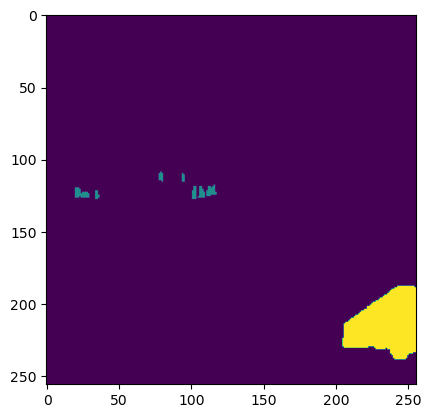

In [220]:
plt.imshow(img_batch[0,:,:,3])

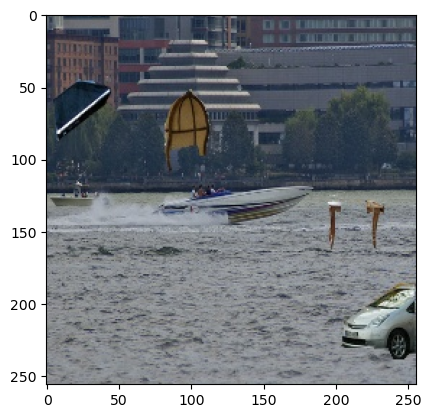

In [221]:
plt.imshow(img_batch[0,:,:,0:3])

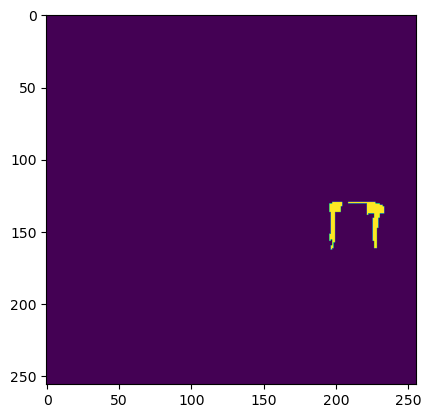

In [232]:
plt.imshow(mask_batch[0,:,:,9])

In [ ]:
plt.imshow(mask_batch[0,:,:,3:6])

In [208]:
# import tensorflow as tf

# # Paso 1: copiar contenido del dataset original al nuevo archivo
# with tf.io.TFRecordWriter("nuevo_dataset.tfrecord") as writer:
#     for record in tf.data.TFRecordDataset("original.tfrecord"):
#         writer.write(record.numpy())

#     # Paso 2: añadir nuevos ejemplos
#     for img_id in nuevas_imagenes:
#         example = serialize_example(img_id, coco, DIR_TRAIN_IMGS, id_objetives)
#         writer.write(example)

### 1.2 Data augmentation

Se modifica la fase de data augmentation para no afectar al canal que contiene la salida del pipeline de la primera fase de la inferencia. La nueva función de data augmentation es tal que:



In [209]:
category_info_objetive

{1: 'person',
 3: 'car',
 4: 'motorcycle',
 6: 'bus',
 10: 'traffic light',
 27: 'backpack',
 31: 'handbag',
 77: 'cell phone',
 62: 'chair',
 67: 'dining table',
 0: 'background'}